<a href="https://colab.research.google.com/github/agamthind96/Deep-Learning-Projects/blob/main/Transfer_Learning_TensorFlow_Part1_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer-Learning-TensorFlow-Part1-Feature-Extraction

Transfer-Learning is leveraging a working model's existing architecture and learn patterns from it for our own problems.

There are 2 main benefits :
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those pattern to our own data.

## Downloading and becoming one with data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file.
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-11-17 08:15:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 108.177.112.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.234.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   137MB/s    in 1.2s    

2021-11-17 08:15:43 (137 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images are there in each folder ?
import os 

# Walk through 10 percent data directory and list the number of files.
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 10 director

# Creating data loaders (Prepare the data)

We will use the **ImageDataGenerator** class to load our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE= (224,224)
BATCH_SIZE = 32
 
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images :")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Test Images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = IMAGE_SHAPE,
                                             batch_size = BATCH_SIZE,
                                             class_mode = "categorical")

Training Images :
Found 750 images belonging to 10 classes.
Test Images
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality that you can add to your model to be performed during or after training. Some of the most popular callbacks:
* Tracking experiment with TensorBoard callback.
* Model checkpoint with the ModelCheckPoint callback.
* Stopping a model from training (before it trains too long nad overfits) with the EarlyStopping callback.


In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to: {log_dir}')
  return tensorboard_callback

## Creating models using TensorFlow Hub.

In the past we have used TensorFlow to create our own models layer by layer from scratch.

Now we are going to do the similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on "https://www.tensorflow.org/hub"

Browsing the TensorFlow Hub page and sorting for Image classification, we found the following Feature Vector model link : https://tfhub.dev/google/efficientnet/b0/feature-vector/1



In [ ]:
# Let's compare the following 2 models :
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"




In [ ]:
# Import Dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args :
    model_url(str) :  A TensorFlow Hub Feature Extraction URL.
    num_classes (int) : Number of output neurons in the output layer,
    should be equal to number of target classes, default 10.

  Returns :
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense Output layer with num_classes output neurons.

  """
  # Download the pre-trained model and save it as a Keras layer.
  feature_extractor_layer = hub.KerasLayer(model_url,
                                          trainable=False, # Freeze the already learnt patterns.
                                          name="feature_extraction_layer",
                                          input_shape = IMAGE_SHAPE + (3,))
  
  # Create our own model
  model = tf.keras.Sequential([
          feature_extractor_layer,
          layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model


## Creating and Testing ResNet TensorFlow Hub Feature Extraction model.

In [ ]:
# Create ResNet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile our ResNet model
resnet_model.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow-hub",
                                                                         experiment_name="resnet50v2",
                                                                         )])


Saving TensorBoard log files to: tensorflow-hub/resnet50v2/20211117-081601
Epoch 1/5
24/24 [==============================] - 59s 1s/step - loss: 1.7765 - accuracy: 0.4107 - val_loss: 1.1104 - val_accuracy: 0.6592
Epoch 2/5
24/24 [==============================] - 22s 921ms/step - loss: 0.8288 - accuracy: 0.7507 - val_loss: 0.8188 - val_accuracy: 0.7396
Epoch 3/5
24/24 [==============================] - 21s 915ms/step - loss: 0.5811 - accuracy: 0.8280 - val_loss: 0.7604 - val_accuracy: 0.7512
Epoch 4/5
24/24 [==============================] - 21s 917ms/step - loss: 0.4539 - accuracy: 0.8773 - val_loss: 0.7238 - val_accuracy: 0.7620
Epoch 5/5
24/24 [==============================] - 21s 908ms/step - loss: 0.3678 - accuracy: 0.9053 - val_loss: 0.6820 - val_accuracy: 0.7680


In [ ]:
 # Let's create a function to plot loss curves.
 import matplotlib.pyplot as plt

 # Plot the validation and training curves.
 def plot_loss_curves(history):
   
   """
   Returns seperate loss curves for training and validation metrics.

   Args :
      history : TensorFlow history object.

   Returns :
      Plot of training/validation loss and accuracy metrics.

   """
   loss = history.history["loss"]
   val_loss = history.history["val_loss"]

   accuracy = history.history["accuracy"]
   val_accuracy = history.history["val_accuracy"]

   epochs = range(len(history.history["loss"]))

   # Plot loss
   plt.plot(epochs, loss, label="Training_loss")
   plt.plot(epochs, val_loss, label="Validation_loss")
   plt.title("Loss")
   plt.xlabel("Epochs")
   plt.legend();

   # Plot accuracy
   plt.figure()
   plt.plot(epochs, accuracy, label="Training_accuracy")
   plt.plot(epochs, val_accuracy, label="Validation_accuracy")
   plt.title("Accuracy")
   plt.xlabel("Epochs")
   plt.legend();




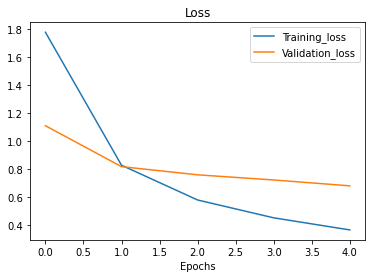

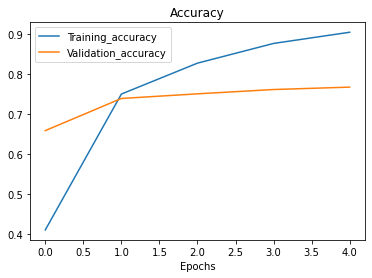

In [ ]:
plot_loss_curves(resnet_history)

## Creating and Testing EfficientNet B0 TensorFlow Hub Feature Extraction model.

In [ ]:
# Creating EfficientNet B0 model
efficientnet_b0_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our EfficientNet model
efficientnet_b0_model.compile(loss="categorical_crossentropy",
                              optimizer=tf.keras.optimizers.Adam(),
                              metrics=["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
efficientnet_b0_history = efficientnet_b0_model.fit(train_data_10_percent,
                                                    epochs=5,
                                                    steps_per_epoch=len(train_data_10_percent),
                                                    validation_data=test_data,
                                                    validation_steps=len(test_data),
                                                    callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                               experiment_name="efficientnetb0")])
                                                    


Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20211117-081831
Epoch 1/5
24/24 [==============================] - 25s 871ms/step - loss: 1.8389 - accuracy: 0.4627 - val_loss: 1.3059 - val_accuracy: 0.7280
Epoch 2/5
24/24 [==============================] - 19s 800ms/step - loss: 1.0503 - accuracy: 0.7773 - val_loss: 0.8746 - val_accuracy: 0.8072
Epoch 3/5
24/24 [==============================] - 18s 791ms/step - loss: 0.7537 - accuracy: 0.8240 - val_loss: 0.7033 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 18s 792ms/step - loss: 0.6069 - accuracy: 0.8573 - val_loss: 0.6157 - val_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 18s 791ms/step - loss: 0.5144 - accuracy: 0.8787 - val_loss: 0.5633 - val_accuracy: 0.8628


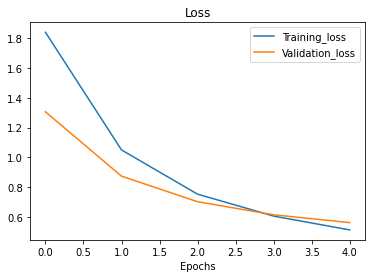

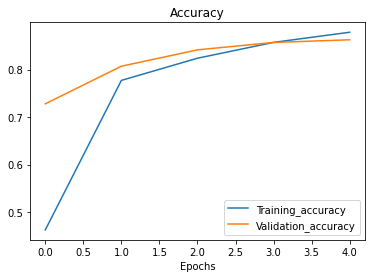

In [ ]:
plot_loss_curves(efficientnet_b0_history)

## Different types of Transfer Learning

*  **As is Transfer Learning**  - using an existing model with no changes whatsoever (eg: Using ImageNet model on 1000 ImageNet classes, none of your own).
*  **Feature Extraction Transfer Learning** - Use the pre-learned patterns of an existing model (eg: EfficientNet B0 trained on ImageNet) and adjust the output layer for your own problem(eg: 1000 classes->10 classes of food)
* **Fine-Tuning Transfer Learning** - Use the pre-learned patterns of an existing model and fine-tune many or all of the underlying layers (including new output layers).

### Comparing our models results using TensorBoard.

> **Note :** When you upload things to TensorBoard Dev, your experiments are public. So, if you're running private experiments,
(things you don't want others to see) don't upload them to TensorBoard Dev

In [ ]:
# Upload TensorBoard Dev records.
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EffcientNetB0 v/s ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot



***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=EQO9vVVYOo2F4qXs1hjUnTFpFGNfoj&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publically here : https://tensorboard.dev/experiment/zbleW45lTjKhARLflDw8NQ/

In [ ]:
# Check out what TensorBoard experiments you have.
!tensorboard dev list

https://tensorboard.dev/experiment/zbleW45lTjKhARLflDw8NQ/
	Name                 EffcientNetB0 v/s ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   zbleW45lTjKhARLflDw8NQ
	Created              2021-11-17 08:56:05 (10 minutes ago)
	Updated              2021-11-17 08:56:05 (10 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              30
	Tensor bytes         0
	Binary object bytes  1420772
Total: 1 experiment(s)


In [ ]:
# Delete an experiment (which you don't want to show publically)

"""
!tensorboard dev delete --experiment_id zbleW45lTjKhARLflDw8NQ
"""

'\n!tensorboard dev delete --experiment_id zbleW45lTjKhARLflDw8NQ\n'